> Code to accompany **Chapter 6: Methods for Generating Adversarial Perturbation**

# Fashion-MNIST Foolbox Boundary Attack

The boundary attack iteratively refines the adversarial perturbation based on query responses from the DNN model. It is a black-box attack requiring no knowledge of the model architecture or its parameters. 

See chapter 6 for a detailed description of this attack.

The boundary attack was proposed by Brendel et al. in ["Decision-Based Adversarial Attacks: Reliable Attacks Against Black-Box Machine Learning Models", Proceedings of the International Conference on Learning Representations (2018)](https://arxiv.org/abs/1712.04248).


## Load in the model and its predictions


Import the key libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

Load in the Fashion-MNIST model and get its predictions.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
_, (test_images, test_labels) = fashion_mnist.load_data()
test_images = test_images/255.0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = tf.keras.models.load_model('../models/fashionMNIST.h5')
predictions = model.predict(test_images)

Instructions for updating:
Colocations handled automatically by placer.


## Select the original (non-adversarial) image


The boundary attack begins with the target classification image rather than the original image. It iteratively moves the image closer to the original, while never allowing each iterative step to alter the adversarial classification by straying across the classification boundary.

First, we select and display the original image - this is the one that we want the adversarial image to look like.

Prediction for original image: 7 Sneaker


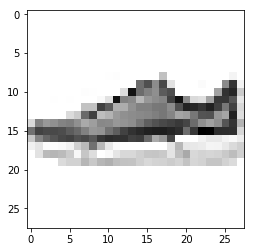

In [3]:
original_image_num = 9

x = test_images[original_image_num]
y = np.argmax(predictions[original_image_num])
y_name = class_names[y]

print("Prediction for original image:", y, y_name)

plt.imshow(x, cmap=plt.cm.binary)


Now, let's get a target image. This gives us our target adversarial classification.

Prediction for starting point image: 5 Sandal


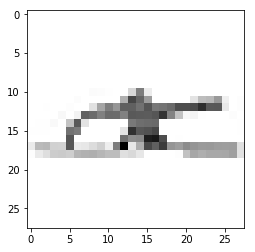

In [4]:
starting_point_image_num = 52

starting_point_image = test_images[starting_point_image_num]
y_adv = np.argmax(predictions[starting_point_image_num])
y_adv_name = class_names[y_adv]

print("Prediction for starting point image:", y_adv, y_adv_name) 
import matplotlib.pyplot as plt

plt.imshow(starting_point_image, cmap=plt.cm.binary)


## Get a Foolbox model from our Keras one¶
Create a Foolbox model from our Keras one. 

In [5]:
import foolbox
fmodel = foolbox.models.TensorFlowModel.from_keras(model, bounds=(0, 1))

## Define the attack specificity

[foolbox.criteria](https://foolbox.readthedocs.io/en/latest/modules/criteria.html) defines the attach specificity (targeted versus untargeted) and the probability threshold required. In this case, we specify a target attack and the target class.
 

In [6]:
attack_criterion = foolbox.criteria.TargetClass(y_adv)

## Define the attack method

In [7]:
attack = foolbox.attacks.BoundaryAttack(fmodel, criterion=attack_criterion)


## Run the attack

Remember, we start from the target and gradually creap back to the original. We are making the target look more and more like the original, without every allowing it to take a step that will change its classification.

In [11]:
x_adv = attack(input_or_adv=x, 
               label = y,
               starting_point = starting_point_image,
               unpack = False,
               iterations = 2000,
               log_every_n_steps = 500)

run with verbose=True to see details
Step 0: 5.60511e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 500: 9.93002e-03, stepsizes = 1.5e-02/2.0e-03: d. reduced by 0.59% (5.9107e-05) (took 0.02669 seconds)
Step 1000: 9.88033e-04, stepsizes = 3.4e-02/2.0e-03: d. reduced by 0.39% (3.9149e-06) (took 0.02609 seconds)
Step 1500: 5.60887e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.9191e-07) (took 0.02581 seconds)
Step 2000: 4.93087e-04, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.01% (5.0676e-08) (took 0.01474 seconds)


## Display the results

If the attack was successful, the images should be different. Take a look to see whether this is the case.

normalized MSE = 4.93e-04


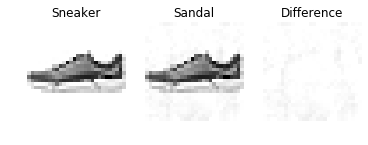

In [14]:
if ((x_adv is None) or (np.array_equal(x, x_adv.image))):
    print("No adversarial example was found")
else:   
    preds = model.predict(np.array([x_adv.image]))

    plt.figure()

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.title(y_name)
    plt.imshow(x, cmap=plt.cm.binary)
    plt.axis('off')

    # Plot the adversarial image
    plt.subplot(1, 3, 2)
    plt.title(class_names[np.argmax(preds[0])])
    plt.imshow(x_adv.image, cmap=plt.cm.binary)
    plt.axis('off')

    # Plot the difference
    plt.subplot(1, 3, 3)
    plt.title('Difference')
    difference = x_adv.image - x
    plt.imshow(difference, vmin=0, vmax=1, cmap=plt.cm.binary)
    plt.axis('off')
    
    plt.show()


## Create and view the intermediate perturbations

If you are interested in seeing the images 

In [10]:
num_iterations = 12
perturbed_images = np.empty((num_iterations,28,28))

                         
for iterations in range (num_iterations):
    print(iterations)
    x_adv = attack(input_or_adv = x, 
                   label = y,
                   iterations = iterations*100,
                   starting_point = starting_point_image,
                   log_every_n_steps = 100)
    perturbed_images[iterations] = x_adv

0
run with verbose=True to see details
Step 0: 5.60511e-02, stepsizes = 1.0e-02/1.0e-02: 
1
run with verbose=True to see details
Step 0: 5.60511e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 100: 3.46021e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.03304 seconds)
2
run with verbose=True to see details
Step 0: 5.60511e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 100: 3.43713e-02, stepsizes = 1.0e-02/4.4e-03:  (took 0.04279 seconds)
Step 200: 3.04150e-02, stepsizes = 6.7e-03/1.3e-03: d. reduced by 0.26% (8.0264e-05) (took 0.02425 seconds)
3
run with verbose=True to see details
Step 0: 5.60511e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 100: 3.34629e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.05117 seconds)
Step 200: 2.70096e-02, stepsizes = 6.7e-03/1.3e-03: d. reduced by 0.39% (1.0702e-04) (took 0.02393 seconds)
Step 300: 2.23219e-02, stepsizes = 6.7e-03/8.8e-04: d. reduced by 0.18% (3.9245e-05) (took 0.02608 seconds)
4
run with verbose=True to see details
Step 0: 5.60511e-02, stepsizes = 1.0e-02/1.0e-02:

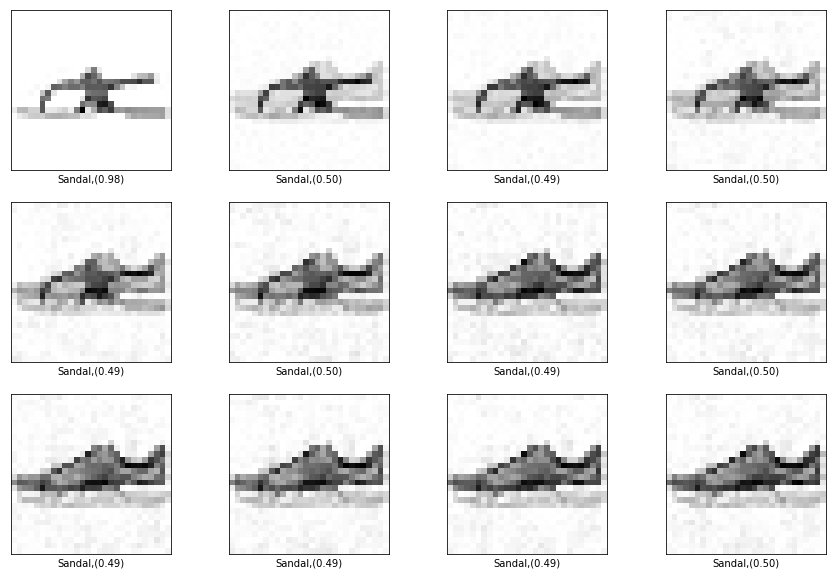

In [11]:
plt.figure(figsize=(15, 10))

perturbed_predictions = model.predict(perturbed_images)

for i in range(num_iterations):
    plt.subplot(3,4,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(perturbed_images[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(perturbed_predictions[i]) # the label should always be the target
    plt.xlabel("{},({:.2f})".format(class_names[predicted_label],
                                    perturbed_predictions[i][predicted_label]))  



## Where next?

Take a look at other attacks. For example:

* The Foolbox Gradient Attack (white box). Here's the [Jupyter notebook on GitHub](https://github.com/katywarr/strengthening-dnns/blob/master/chapter06/fashionMNIST_foolbox_gradient.ipynb) and here's the [relative path to the Jypyter notebook](./fashionMNIST_foolbox_gradient.ipynb) if you want to run it.


Want to move on to more complicated images? Try:

* The Foolbox saliency attack using the ResNet50 classifier. Here's the [Jupyter notebook on GitHub](https://github.com/katywarr/strengthening-dnns/blob/master/chapter06/resnet50_foolbox_saliency.ipynb) and here's the [relative path to the Jypyter notebook](./resnet50_foolbox_saliency.ipynb) if you want to run it.

There are many more examples of adversarial attacks online. See [RESOURCES.md](https://github.com/katywarr/strengthening-dnns/blob/master/RESOURCES.md) for links to collaborative projects for creating and defending against attacks.